In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [15]:
map_df = gpd.read_file('../src_data/us_county_mainland/us_county.shp')

In [16]:
data_dir = '../statistical_approach/test/'
data_fn = 'simu_%d_region_level.csv'
pop_fn = '../src_data/usa_%s_population.csv'
data_df = pd.read_csv(data_dir+data_fn%0, dtype={'GeoId':str})

In [17]:
len_geoid = len(data_df.loc[0,'GeoId'])
if len_geoid == 5:
    region_level = 'county'
elif len_geoid == 11:
    region_level = 'census_tract'
else:
    region_level = 'cbg'

In [19]:
data_df['GeoId'] = data_df['GeoId']
data_df['Infected'] = data_df['Infectious'] + data_df['Recovered']
data_df = data_df.drop_duplicates(subset=['GeoId','Infected'])
data_df = data_df.groupby(['Day','GeoId']).sum().reset_index()

In [27]:
data_df['Infected'].max()

19

In [22]:
pop_data = pd.read_csv(pop_fn%region_level, dtype={'GeoId':str})
pop_data['Infected-plot'] = 0
for d in range(len(data_df['Day'].unique())):
    fig, ax = plt.subplots(figsize = (20,20))
    
    plot_data = pop_data.join(data_df[data_df['Day'] == d].set_index('GeoId')['Infected'], on = 'GeoId', how = 'left')
    plot_data['Infected'] = plot_data['Infected'].fillna(plot_data['Infected-plot'])
    pop_data['Infected-plot'] = plot_data['Infected']

    plot_data['GeoId'] = plot_data['GeoId'].apply(lambda x: x[:5])
    plot_data = plot_data.groupby('GeoId')[['Population','Infected']].sum().reset_index()
    prob_map_df = map_df.merge(plot_data, left_on='GEOID', right_on='GeoId', how = 'left').fillna(0)
    prob_map_df.plot(column='Infected', cmap='Blues', ax = ax, linewidth = 0.1, legend=True , vmin=0, vmax=30, legend_kwds={'shrink': 0.5, 'orientation':'horizontal'})
    ax.axis('off')
    ax.annotate(f'Day: {d}', xy=(0.5, 1.05), xycoords='axes fraction', fontsize=12, ha='center')
    
    fig.savefig('test-viz/%d.png'%d)
    plt.close(fig)

In [25]:
from matplotlib.widgets import Slider
from PIL import Image
import os
import numpy as np

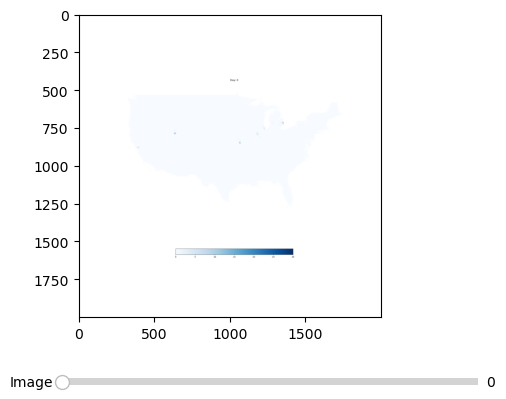

In [26]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png')):
            try:
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path)
                images.append(np.array(img))
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# Path to your image folder
image_folder = "test-viz"

# Load images
image_list = load_images_from_folder(image_folder)

if not image_list:
    print("No images found in the specified folder.")
else:
    # Set up the figure and axes
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    current_image_index = 0
    im = ax.imshow(image_list[current_image_index])

    # Create slider axis
    ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])

    # Create slider
    slider = Slider(ax_slider, "Image", 0, len(image_list) - 1, valinit=current_image_index, valstep=1)

    # Function to update the image
    def update(val):
        global current_image_index
        current_image_index = int(slider.val)
        im.set_data(image_list[current_image_index])
        fig.canvas.draw_idle()

    # Connect slider to update function
    slider.on_changed(update)

    plt.show()